# Milestone Project 2: SkimLit 

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier 

The paper we're replicating (the souruce of the dataset we'll be using) is available here : 

And reading through the paper above, we see the model architecture that they use to achieve their best results is available here: 

## Confirm access to a GPU 

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get Data 

Since we'll be replicating the paper above (PubMed 200k), let's download the dataset they used. 

We can download their dataset from github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
  # Check what files are in the PubMed20k 
  !ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start ouru experiments using the 20k dataset with numbers replaced by "@" 
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preporcess data 

Now we've got some text data, it's time to become one with it. 

One of the best ways to become one with the data is to 

> Visualize, Visualize, Visualize 

With that in mind, let's write a function to read in all of the lines of a target text file


In [ ]:
# Create function to read the lines of a docuument 
def get_lines(filename):
  """
  Reads a text filename and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, "r") as f:
    return f.readlines()


In [ ]:
# Let's read in the training lines 
train_lines = get_lines(data_dir +"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look
```
`[{'line nuumber': 0, 
 'target' : 'BACKGROUND',  
  'text': To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade,  
  'total_lines': 11}]`
```






In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data 

  Takes in filename, reads it contents and sort through each line, 
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence the target line is
  """

  input_lines = get_lines(filename) # get all the lines 
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = "" # resets the abstract string if the line is a new abstract
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number , abstract_line  in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target  label from split
        line_data['target'] = target_text_split[0] # get target label 
        line_data['text'] = target_text_split[1].lower() # get the target text and lower case it
        line_data['line_number'] = abstract_line_number 
        line_data['total_lines'] = len(abstract_line_split) -1
        abstract_samples.append(line_data)
 
    else: # if the above conditions aren't fulfilled the line constains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 884 ms, sys: 215 ms, total: 1.1 s
Wall time: 1.45 s


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries how abouut we turn it into a DataFrame to further visualize it 

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

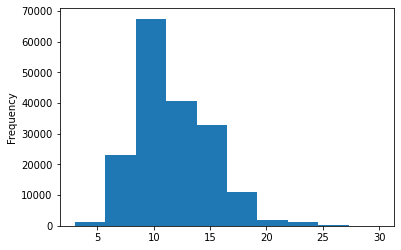

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences) , len(test_sentences)

(180040, 30212, 30135)

## Make numberic labels (ML models require numeric labels as well as data)

In [ ]:
# One hot encode lables
import sklearn
from sklearn.preprocessing import OneHotEncoder
print(sklearn.__version__)

1.0.2


In [ ]:
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
train_labels_one_hot, val_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]))

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [ ]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classe sfrom LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting a series of modelling experiments 

## Model 0: Getting a baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline 
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ('clf' , MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X= train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-25 15:42:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-25 15:42:06 (58.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true= val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [ ]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len =  np.mean(sent_lens)
avg_sent_len

26.338269273494777

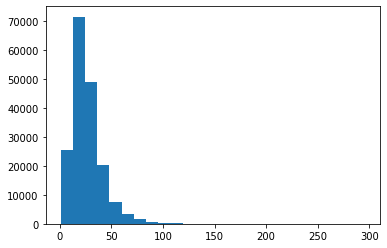

In [ ]:
# What's the distribtuion look like 
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 25);

In [ ]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Max sequence length in the training set 
max(sent_lens)

296

### Create text vectorizer layer 

We want to create a layer that tokenizes our data

In [ ]:
# How many words are in our vocab
max_tokens = 68000

In [ ]:
# Create text vectorizer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random 
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text:{len(target_sentence)}")
print(f"\nVectorized Text: {text_vectorizer([target_sentence])}")

Text:
 in randomized order , de , tai and fc were performed .

Length of text:54

Vectorized Text: [[   5   29  923 1994 5166    3 4277    9  153    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary 
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")


Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding 

In [ ]:
# Create token embedding layer 
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,# Different embedding sizes result in drastically different number of parameters
                               mask_zero = True,# use masking to handle variable sequence lengths (save space)
                               name = 'token_embedding')

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 in randomized order , de , tai and fc were performed .

Sentence after vectorization (before embedding): 
 [[   5   29  923 1994 5166    3 4277    9  153    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding: 
 [[[ 0.01129127 -0.03335558  0.03279935 ... -0.02357062 -0.04357976
    0.02236194]
  [-0.0444711  -0.03640361 -0.02279323 ... -0.01170849 -0.04101242
   -0.0338214 ]
  [-0.02923319 -0.00792762 -0.04120971 ... -0.04305178 -0.02468232
   -0.037696  ]
  ...
  [ 0.02194856 -0.03231615  0.02622935 ...  0.00310351 -0.00348961
    0.04679114]
  [ 0.02194856 -0.03231615  0.02622935 ...  0.00310351 -0.00348961
    0.04679114]
  [ 0.02194856 -0.03231615  0.02622935 ...  0.00310351 -0.00348961
    0.04679114]]]

Embedded sentence shape: (1, 55, 128)


## Creating datasets 

Making sure our data loads as fast as possible with the TensorFlow tf.data.API

In [ ]:
# Turn our data into tensorflow datasets
train_dataset =tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset =tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset =tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take tensorflow datasets and  turn them into prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with token embeddings

In [ ]:
# Create the 1D conv model to process sequences 
inputs = layers.Input(shape = (1,), dtype= tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings) 
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile 
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        epochs = 3, 
                        validation_data = val_dataset,
                        validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 65s 113ms/step - loss: 0.9189 - accuracy: 0.6384 - val_loss: 0.6827 - val_accuracy: 0.7410
Epoch 2/3
562/562 [==============================] - 62s 109ms/step - loss: 0.6520 - accuracy: 0.7603 - val_loss: 0.6284 - val_accuracy: 0.7666
Epoch 3/3
562/562 [==============================] - 62s 111ms/step - loss: 0.6137 - accuracy: 0.7762 - val_loss: 0.5941 - val_accuracy: 0.7849


In [ ]:
# Evaluate on whole validation datset
model_1.evaluate(val_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.5935 - accuracy: 0.7875


[0.5934754014015198, 0.787534773349762]

In [ ]:
# Make predictions (our model predicts prediction probabilites for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.4172823e-01, 1.9870645e-01, 4.9609914e-02, 2.8611204e-01,
         2.3843419e-02],
        [3.9903185e-01, 3.3559802e-01, 1.2744376e-02, 2.3726742e-01,
         1.5358364e-02],
        [1.6747965e-01, 4.2820764e-03, 1.9244911e-03, 8.2624090e-01,
         7.2910836e-05],
        ...,
        [8.6883729e-06, 1.0029138e-03, 9.7641948e-04, 5.5832961e-06,
         9.9800640e-01],
        [4.4991124e-02, 4.7435856e-01, 6.8028793e-02, 4.8099358e-02,
         3.6452219e-01],
        [2.1400148e-01, 6.8180418e-01, 5.4682862e-02, 3.4516368e-02,
         1.4995058e-02]], dtype=float32), (30212, 5))

In [ ]:
# Conver pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs,axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1_results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.75347544022243,
 'precision': 0.784133024805679,
 'recall': 0.7875347544022243,
 'f1': 0.7848557870693764}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2 : Feature extraction with pretrained token embeddings 

Now let's use pretrained word embeddings from TensorFlow Hub more specifically the universal sentence encoder.

The paper originally used GloVe embeddings however we are going to stick with USE (univeral sentence encoder)

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable =False, 
                                        name = 'universal_sentence_encoder')

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Embedded sentence:\n {use_embedded_sentence[0][:30]}")

Random sentence:
 postoperative complications occurred in @ of @ patients ( @ % ) receiving placebo and in @ of @ patients ( @ % ) receiving atorvastatin ( p = @ ) .
Embedded sentence:
 [-0.0493884   0.03231776  0.0374336  -0.050201    0.0613159   0.06802374
 -0.00776399 -0.00468094 -0.01586251 -0.0517498   0.08742339 -0.0496687
 -0.00962633  0.00504563 -0.01857326  0.00426668 -0.08840621 -0.03985519
 -0.08248706 -0.05963302  0.06889875  0.07490701  0.04374778  0.00132766
  0.01124734 -0.00999045 -0.03443022 -0.05450167  0.04807758  0.00234549]


### Building and fitting an NLP feature extraction model using pretrained embeddings using pretrained embeddings from TensorFlow Hub

In [ ]:
# Define feature extraction layer 
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embbedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu')(pretrained_embbedding)
# Note: we could add more layers here if we wanted to try and improve performance
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE_feature_extractor")

# Compile the model 
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch = int(0.1* len(train_dataset)),
                        epochs = 3, 
                        validation_data = val_dataset,
                        validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9194 - accuracy: 0.6494 - val_loss: 0.7983 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7695 - accuracy: 0.7019 - val_loss: 0.7559 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7526 - accuracy: 0.7125 - val_loss: 0.7401 - val_accuracy: 0.7114


In [ ]:
# Evaluate on whole val dataset 
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7422 - accuracy: 0.7124


[0.7422041893005371, 0.7124321460723877]

In [ ]:
# Make predict probability 
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[4.2787698e-01, 3.6556613e-01, 1.8226509e-03, 1.9815657e-01,
        6.5776417e-03],
       [3.2686505e-01, 5.3674078e-01, 3.3202446e-03, 1.3031189e-01,
        2.7621775e-03],
       [2.2174254e-01, 1.6106352e-01, 1.6187837e-02, 5.6164849e-01,
        3.9357550e-02],
       ...,
       [2.2133912e-03, 6.6718427e-03, 5.7653721e-02, 7.9316844e-04,
        9.3266791e-01],
       [4.3485118e-03, 4.3155525e-02, 2.0321408e-01, 1.7326764e-03,
        7.4754924e-01],
       [1.9591056e-01, 2.8429082e-01, 4.4830862e-01, 1.0289339e-02,
        6.1200675e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate model_2_results
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.2432146167086,
 'precision': 0.712631463277371,
 'recall': 0.712432146167086,
 'f1': 0.7093282387755732}

In [ ]:
# Compare with baseline
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings 

The paper which we are replicating states that they used a combination of token and character embedding. 

Previously we've use token-level embedding but we will need to do similar steps for characters if we want to us char-level embeddings

In [ ]:
### Creating a character level tokenizer 
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make a function to split sentences into characters
def split_chars(text): 
  return " ".join(list(text))

split_chars(random_train_sentence)

'p o s t o p e r a t i v e   c o m p l i c a t i o n s   o c c u r r e d   i n   @   o f   @   p a t i e n t s   (   @   %   )   r e c e i v i n g   p l a c e b o   a n d   i n   @   o f   @   p a t i e n t s   (   @   %   )   r e c e i v i n g   a t o r v a s t a t i n   (   p   =   @   )   .'

In [ ]:
# Split sequence-level data splits into characater level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# whats the average character length now with spaces
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

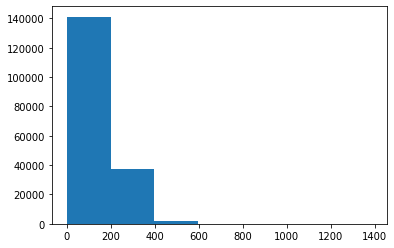

In [ ]:
# Check the distribution of the sequence at the character level 
import matplotlib.pyplot as plt
plt.hist(char_len, bins = 7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string 
alphabet= string.ascii_lowercase + string.digits + string.punctuation
alphabet 

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char- level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)  + 2 # add 2 for space and OOV token (OOV = out of vocab variabele)
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = 'char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character 
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab :{len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab :28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer 
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\n Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 e r a d i c a t i o n   o f   d .   f r a g i l i s   w a s   s i g n i f i c a n t l y   g r e a t e r   i n   t h e   m e t r o n i d a z o l e   g r o u p   ,   a l t h o u g h   i t   d e c l i n e d   r a p i d l y   f r o m   @   %   @   w e e k s   a f t e r   e n d   o f   t r e a t m e n t   t o   @   %   @   w e e k s   a f t e r   e n d   o f   t r e a t m e n t   .

Length of random_train_chars: 156

Vectorized chars:
 [[ 2  8  5 10  4 11  5  3  4  7  6  7 17 10 17  8  5 18  4 12  4  9 20  5
   9  9  4 18  6  4 17  4 11  5  6  3 12 19 18  8  2  5  3  2  8  4  6  3
  13  2 15  2  3  8  7  6  4 10  5 25  7 12  2 18  8  7 16 14  5 12  3 13
   7 16 18 13  4  3 10  2 11 12  4  6  2 10  8  5 14  4 10 12 19 17  8  7
  15 20  2  2 23  9  5 17  3  2  8  2  6 10  7 17  3  8  2  5  3 15  2  6
   3  3  7 20  2  2 23  9  5 17  3  2  8  2  6 10  7 17  3  8  2  5  3 15
   2  6  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  

### Creating a character level embedding 

In [ ]:
# Create char embedding layer 
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = 'char_embed'
                              )

In [ ]:
# Test out character embedding layer 
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding) :\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 e r a d i c a t i o n   o f   d .   f r a g i l i s   w a s   s i g n i f i c a n t l y   g r e a t e r   i n   t h e   m e t r o n i d a z o l e   g r o u p   ,   a l t h o u g h   i t   d e c l i n e d   r a p i d l y   f r o m   @   %   @   w e e k s   a f t e r   e n d   o f   t r e a t m e n t   t o   @   %   @   w e e k s   a f t e r   e n d   o f   t r e a t m e n t   .

Embedded chars. (after vectorization and embedding) :
 [[[-0.00099404 -0.02889436 -0.03486234 ... -0.0323867   0.01633556
   -0.04077988]
  [-0.04228112 -0.01112266 -0.03238721 ... -0.01439802 -0.0467459
    0.04270856]
  [-0.02527027 -0.02907209 -0.03881096 ...  0.02081137 -0.01313412
    0.03084231]
  ...
  [ 0.03639693  0.01812297 -0.01246493 ...  0.01965166  0.04713962
   -0.01037605]
  [ 0.03639693  0.01812297 -0.01246493 ...  0.01965166  0.04713962
   -0.01037605]
  [ 0.03639693  0.01812297 -0.01246493 ...  0.01965166  0.04713962
   -0.01037605]]]

Character embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

379

### Building a Conv1D model to fit on character embedding

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make conv1D on chars only
inputs = layers.Input(shape=(1,), dtype = 'string')
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_conv1d_char_embeddings')

# Compile model
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch = int(0.1*len(train_char_dataset)),
                        epochs = 3,
                        validation_data = val_char_dataset,
                        validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 34ms/step - loss: 1.4590 - accuracy: 0.3511 - val_loss: 1.4062 - val_accuracy: 0.3983
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 1.3668 - accuracy: 0.4243 - val_loss: 1.3351 - val_accuracy: 0.4405
Epoch 3/3
562/562 [==============================] - 19s 33ms/step - loss: 1.3243 - accuracy: 0.4517 - val_loss: 1.3112 - val_accuracy: 0.4478


In [ ]:
# Make predictions with character model only 
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.16366692, 0.2243874 , 0.31839523, 0.13667081, 0.15687965],
       [0.11426273, 0.16890882, 0.16290215, 0.06849256, 0.4854337 ],
       [0.09636277, 0.14771014, 0.46447977, 0.09163611, 0.19981116],
       ...,
       [0.0586656 , 0.10119858, 0.24375072, 0.0412154 , 0.5551697 ],
       [0.04985131, 0.10543604, 0.2250288 , 0.04975228, 0.56993157],
       [0.1477419 , 0.18165247, 0.2152778 , 0.07057504, 0.38475287]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [ ]:
# Calculate result
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 45.088044485634846,
 'precision': 0.3765590640151162,
 'recall': 0.4508804448563485,
 'f1': 0.3966678052497419}

In [ ]:
# Compare to baseline
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + characters embedding (hybrid layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a charcter-level embedding model (similar to `model_3`)
3. Combine 1 & 2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3 

In [ ]:
# 1. Setup token inputs/model 
token_inputs = layers.Input(shape = [], dtype = 'string', name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, 
                             outputs = token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding) 
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                   char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

# 5. Construct model with char and token level 
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embedding')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

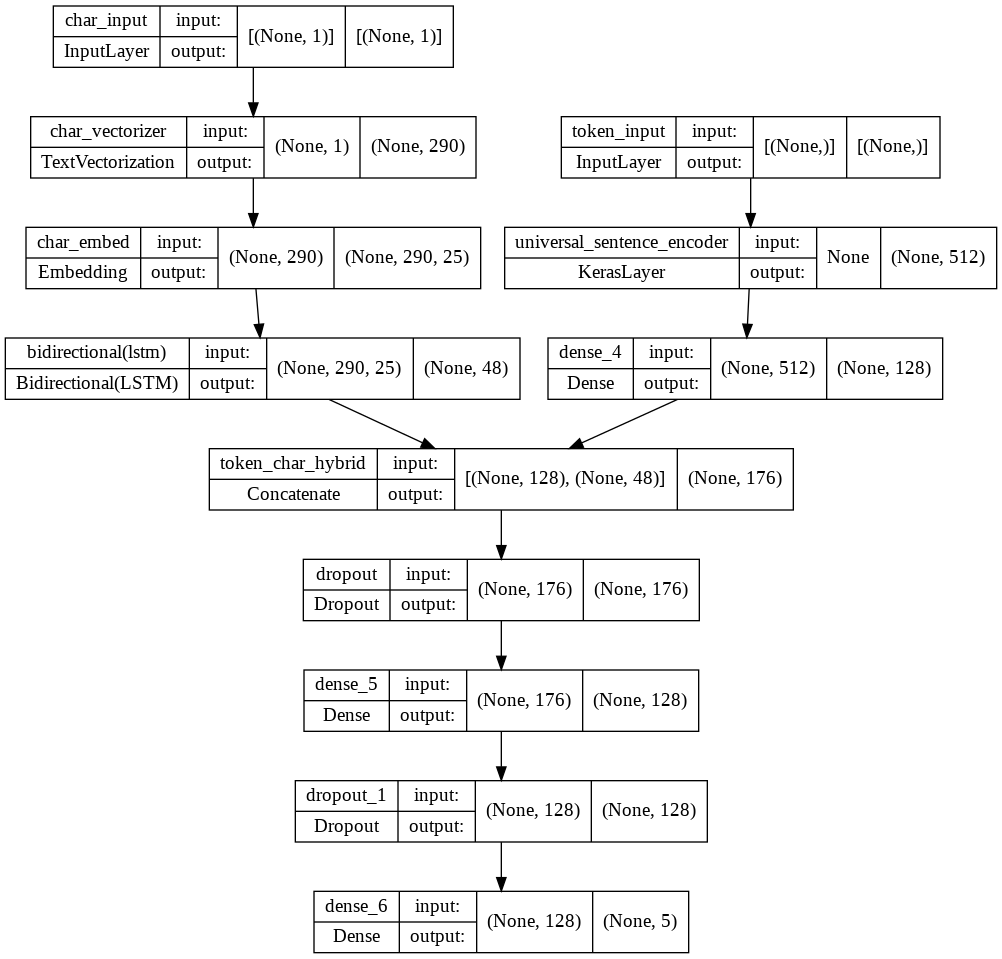

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes =True)

In [ ]:
# Compile  token char model 
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Combining token and character data into a tf.dataset

In [ ]:
train_hybrid_data = tf.data.Dataset.from_tensor_slices(( train_sentences, train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data, train_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_data, val_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_hybrid_data = tf.data.Dataset.from_tensor_slices(( test_sentences, test_chars))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_hybrid_dataset = tf.data.Dataset.zip((test_hybrid_data, test_hybrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_hybrid_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

###Fitting model 4 

In [ ]:
# Fit model
history_4 = model_4.fit(train_hybrid_dataset,
                        steps_per_epoch = int(0.1* len(train_hybrid_dataset)),
                        epochs = 3, 
                        validation_data = val_hybrid_dataset,
                        validation_steps = int(0.1 * len(val_hybrid_dataset)))

Epoch 1/3
562/562 [==============================] - 210s 355ms/step - loss: 0.9875 - accuracy: 0.6059 - val_loss: 0.7842 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 192s 342ms/step - loss: 0.8051 - accuracy: 0.6874 - val_loss: 0.7261 - val_accuracy: 0.7201
Epoch 3/3
562/562 [==============================] - 180s 320ms/step - loss: 0.7797 - accuracy: 0.7043 - val_loss: 0.6929 - val_accuracy: 0.7347


In [ ]:
model_4.evaluate(val_hybrid_dataset)

945/945 [==============================] - 62s 66ms/step - loss: 0.6944 - accuracy: 0.7341


[0.6944079399108887, 0.7341122627258301]

In [ ]:
# Make predictions with character model only 
model_4_pred_probs = model_4.predict(val_hybrid_dataset)
model_4_pred_probs

array([[4.6938759e-01, 3.2223925e-01, 7.5642802e-03, 1.9292152e-01,
        7.8874053e-03],
       [2.8066283e-01, 5.7625055e-01, 5.7855723e-03, 1.3495913e-01,
        2.3418958e-03],
       [3.1763667e-01, 1.2804730e-01, 6.0594611e-02, 4.5549747e-01,
        3.8223948e-02],
       ...,
       [8.2042854e-04, 7.5675403e-03, 6.2181786e-02, 4.3276840e-04,
        9.2899740e-01],
       [6.1739711e-03, 5.6554582e-02, 2.1014622e-01, 2.9985048e-03,
        7.2412670e-01],
       [2.7798939e-01, 4.7320834e-01, 1.7902188e-01, 1.8784273e-02,
        5.0996076e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate result
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.41122732688999,
 'precision': 0.733070876905517,
 'recall': 0.7341122732688998,
 'f1': 0.7306065797808858}

In [ ]:
# Compare with baseline
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**NOTE**: Any engineered features used to train a model need to be available at test time 

### Create positional embeddings

In [ ]:
# How many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

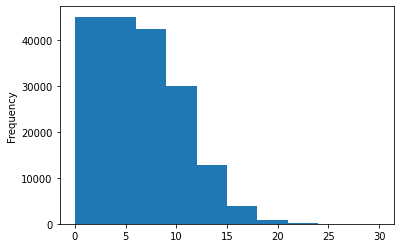

In [ ]:
# Visualize 
train_df.line_number.plot.hist()

In [ ]:
# use tensorflow to create one hot encoded tensors of our line_number column 
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do it again for our total line feature

In [ ]:
# How many different line numbers are there
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

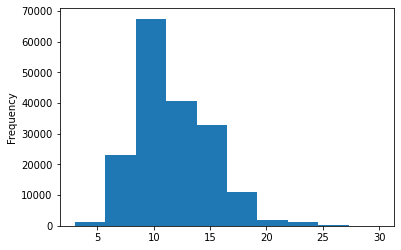

In [ ]:
# Visualize 
train_df['total_lines'].plot.hist()

In [ ]:
# Check the coverage of the total lines
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# use tensorflow to create one hot encoded tensors of our total_lines column 
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0


### Building a tribrid embedding model 

1. Create a token level model 
2. Create a character-level main
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the ouputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs 6 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape= [], dtype = 'string', name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs =layers.Dense(128, activation ='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = [1,], dtype = 'string', name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, 
                            outputs = char_bi_lstm) 

# 3. Line numbers model 
line_number_input = layers.Input(shape =(15,), dtype = tf.float32, name ='line_number_input')
line_number_output = layers.Dense(32, activation = 'relu')(line_number_input)
line_number_model = tf.keras.Model(line_number_input, line_number_output)

# 4. Total numbers
total_lines_input = layers.Input(shape =(20,), dtype = tf.float32, name ='total_lines_input')
total_lines_output = layers.Dense(32, activation = 'relu')(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, total_lines_output)

# 5 .Combine 1 & 2
combined_embeddings = layers.Concatenate(name = 'combined_token_embedding')([token_model.output,
                                                                             char_model.output])
# Create a dropout layer
dense_ = layers.Dense(256, activation = 'relu')(combined_embeddings)
dropout_layer = layers.Dropout(0.5)(dense_)

# 6. Combine 3, 4, & 6
tribrid_embeddings = layers.Concatenate(name = 'tribrid_model')([line_number_model.output,
                                                                 total_lines_model.output,
                                                                 dropout_layer])

# 7. Create output layer
output_layer = layers.Dense(5, activation = 'softmax', name = 'output_layer')(tribrid_embeddings)

# 8. Create a model
model_5  = tf.keras.Model(inputs = [line_number_model.input,
                                    total_lines_model.input, 
                                    token_model.input,
                                    char_model.input],
                          outputs = output_layer)

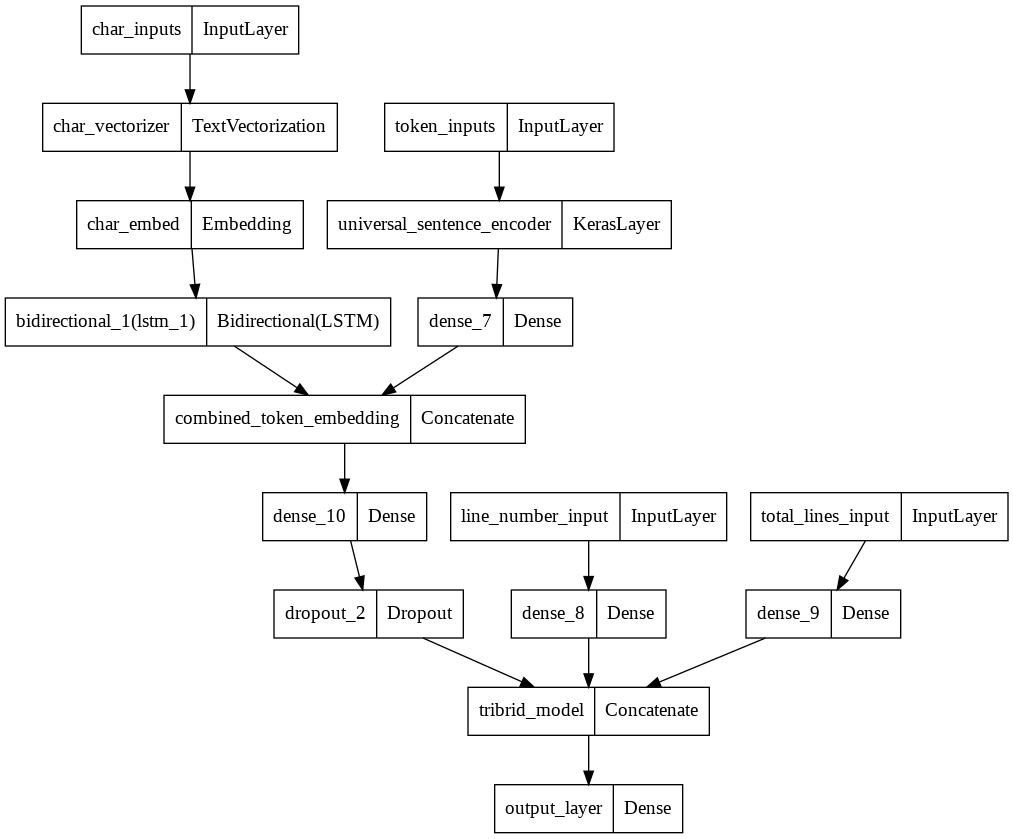

In [ ]:
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Compile token, char and positional embedding model 
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Create tribrid embedding datasets using tf.data

In [ ]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                         train_total_lines_one_hot,
                                                         train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, 
                                                         val_total_lines_one_hot,
                                                         val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, 
                                                         test_total_lines_one_hot,
                                                         test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_tribrid_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit model
history_5 = model_5.fit(train_tribrid_dataset,
                        steps_per_epoch = int(0.1* len(train_tribrid_dataset)),
                        epochs = 3, 
                        validation_data = val_tribrid_dataset,
                        validation_steps = int(0.1 * len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 204s 343ms/step - loss: 1.1021 - accuracy: 0.7200 - val_loss: 0.9858 - val_accuracy: 0.8002
Epoch 2/3
562/562 [==============================] - 182s 324ms/step - loss: 0.9718 - accuracy: 0.8132 - val_loss: 0.9542 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 184s 327ms/step - loss: 0.9544 - accuracy: 0.8215 - val_loss: 0.9385 - val_accuracy: 0.8321


In [ ]:
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 66s 70ms/step - loss: 0.9370 - accuracy: 0.8324


[0.9370178580284119, 0.8323513865470886]

In [ ]:
# Make predictions with character model only 
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs

array([[0.50970834, 0.10174688, 0.01693857, 0.35167593, 0.01993028],
       [0.5177395 , 0.10490549, 0.06618491, 0.30019072, 0.01097936],
       [0.29639837, 0.10269509, 0.17440309, 0.3564767 , 0.0700267 ],
       ...,
       [0.03026973, 0.10454944, 0.04337035, 0.02509685, 0.7967137 ],
       [0.02689289, 0.26879022, 0.06803019, 0.02363208, 0.6126546 ],
       [0.25243297, 0.56278217, 0.08397064, 0.03848419, 0.06233002]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate result
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.23513835562028,
 'precision': 0.8306573063512188,
 'recall': 0.8323513835562029,
 'f1': 0.8312014421439086}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Comparing Results

In [ ]:
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_pretrained_char_embedding': model_3_results,
                                  'model_4_pretrained_token_char_embedding': model_4_results,
                                  'model_5_pretrained_token_char_pos_embedding': model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.753475,0.784133,0.787535,0.784856
model_2_pretrained_token_embedding,71.243215,0.712631,0.712432,0.709328
model_3_pretrained_char_embedding,45.088044,0.376559,0.450880,0.396668
model_4_pretrained_token_char_embedding,73.411227,0.733071,0.734112,0.730607
model_5_pretrained_token_char_pos_embedding,83.235138,0.830657,0.832351,0.831201


In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

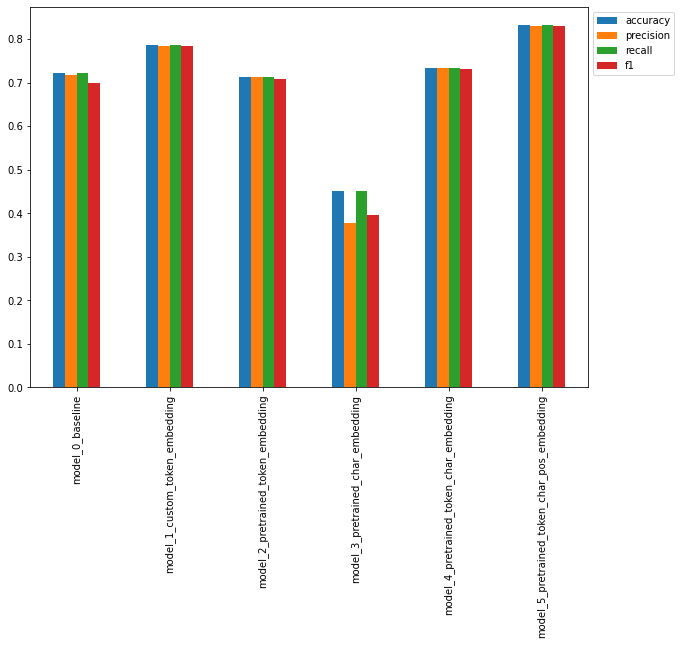

In [ ]:
all_model_results.plot(kind = 'bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));


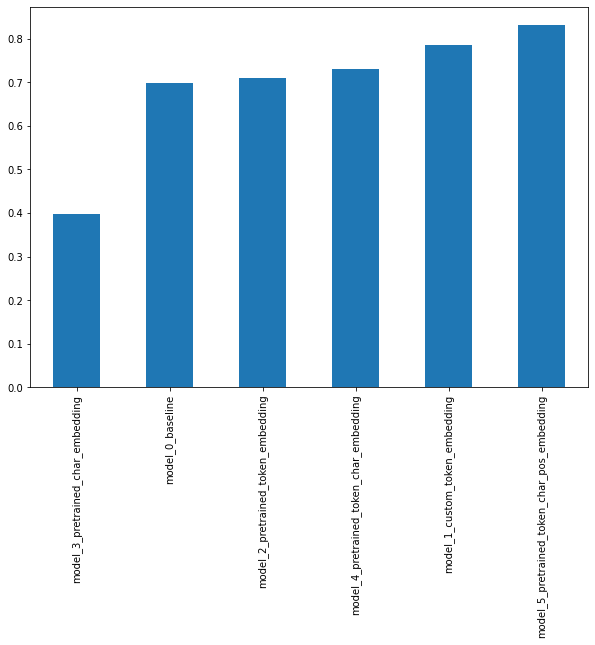

In [ ]:
all_model_results.sort_values('f1', ascending = True)['f1'].plot(kind = 'bar', figsize = (10,7))

# Save and Load model

In [ ]:
# Save the best performing model 
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model 
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions 
loaded_pred_probs = loaded_model.predict(val_tribrid_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
# Download and load in a pretrained model from Google Storage
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model 

--2022-08-25 16:17:14--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 74.125.196.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip.1’

skimlit_tribrid_mod 100%[===================>] 917.97M   137MB/s    in 6.3s    

2022-08-25 16:17:21 (145 MB/s) - ‘skimlit_tribrid_model.zip.1’ saved [962561955/962561955]

mkdir: cannot create directory ‘skimlit_gs_model’: File exists
Archive:  skimlit_tribrid_model.zip
replace skimlit_gs_model/skimlit_tribrid_model/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load in downloaded Google Storage model
model_path = 'skimlit_gs_model/skimlit_tribrid_model'
loaded_gs_model = tf.keras.models.load_model(model_path)

In [ ]:
# Evaluate the loaded google storage model 
loaded_gs_model.evaluate(val_tribrid_dataset)

## Your challenges

1. Turn the test data samples into a tf.data Dataset (fast  loading) and then evaluate the best performing model on the test samples 

2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability)

3. Make example predictions on RCT abstracts from the wild, you can go to PubMed to find these. Find and use our model to predict on 3-4 different abstracts from the wild.

4. See the exercises and extra curriculum section on Github to further test your skills 



In [ ]:
# Challegene 1. 
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                         train_total_lines_one_hot,
                                                         train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, 
                                                         val_total_lines_one_hot,
                                                         val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, 
                                                         test_total_lines_one_hot,
                                                         test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_tribrid_dataset